In [1]:
from darksky import forecast    #API Docs: https://github.com/lukaskubis/darkskylib
from datetime import datetime, timedelta

import psycopg2 as pg
conn = pg.connect(dbname="postgres", user="postgres", password="postgres")
curr = conn.cursor()


In [4]:
#Get historical weather data and store it in local DB.
#2015 and 2016 pulled on Apr 14.
#2017 and 2018 pulled on Apr 15.
#2013 and 2014 pulled on Apr 16.
#2011 and 2012 pulled on Apr 17
#2010 and 2009 pulled on Apr 18
#2008 pulled on Apr 19
#2019 data through Apr 15 pulled on Apr 23 - For demo only, do not train on the 2019 data!!

api_key = "1aa3e82a71c93a310e8b08d9f2bb3c4a"
ut_tower = [30.2861062, -97.7392009]
excluded=['currently,minutely,hourly,alerts,flags']  #Only need 'daily'
forecast_timestamp = datetime(2019, 5, 1, 23, 59, 59)

insert_query = """insert into weather_data values (date'{}',{},{},{},{},{},{},{},'{}')"""

while (forecast_timestamp < datetime(2019, 5, 4, 23, 59, 59)):
    forecast_data = forecast(api_key, *ut_tower, time=forecast_timestamp.isoformat(), exclude=excluded)
    
    try:
        high = forecast_data.daily.data[0].temperatureHigh
    except:
        high = 'NULL'
    try:
        low = forecast_data.daily.data[0].temperatureLow
    except:
        low = 'NULL'
    try:
        precip = forecast_data.daily.data[0].precipProbability
    except:
        precip = 'NULL'
    try:
        pressure = forecast_data.daily.data[0].pressure
    except:
        pressure = 'NULL'
    try:
        cloud = forecast_data.daily.data[0].cloudCover
    except:
        cloud = 'NULL'
    try:
        speed = forecast_data.daily.data[0].windSpeed
    except:
        speed = 'NULL'
    try:
        bearing = forecast_data.daily.data[0].windBearing
    except:
        bearing = 'NULL'

    formatted_query = insert_query.format(str(datetime.utcfromtimestamp(forecast_data.daily.data[0].time))[:10],
                    high,
                    low,
                    precip,
                    pressure,
                    cloud,
                    speed,
                    bearing,
                    'X')
    #curr.execute(formatted_query)
    #conn.commit()
    print(str(datetime.utcfromtimestamp(forecast_data.daily.data[0].time))[:10])
    forecast_timestamp += timedelta(days=1)

2019-05-01
2019-05-02
2019-05-03


In [5]:
#Create categorical wind direction values from the direction degree value.

update_query = """update weather_data set wind_dir = (select case when (wind_deg < 45 or wind_deg > 315) then 'N'
when wind_deg between 45 and 135 then 'E'
when wind_deg between 136 and 224 then 'S'
when wind_deg between 225 and 315 then 'W' end 
from weather_data wd where weather_data.rec_date = wd.rec_date)
where wind_dir not in ('N','E','W','S')"""

#curr.execute(update_query)
#conn.commit()


In [ ]:
#Create sequence of 5 days of X data along with 6th day's Y data using only data which is complete
create_training_table = """
create table weather_data_training
(rec_date_1       date,
 temp_high_1      numeric(5,2),
 temp_low_1      numeric(5,2),
 precip_prob_1    numeric(3,2),
 pres_mbar_1      numeric(6,2),
 cloud_cover_1    numeric(3,2),
 wind_speed_1     numeric(5,2),
 wind_deg_1       numeric(3),
 wind_dir_1       char(1),

 temp_high_2      numeric(5,2),
 temp_low_2      numeric(5,2),
 precip_prob_2    numeric(3,2),
 pres_mbar_2      numeric(6,2),
 cloud_cover_2    numeric(3,2),
 wind_speed_2     numeric(5,2),
 wind_deg_2       numeric(3),
 wind_dir_2       char(1),
 
 temp_high_3      numeric(5,2),
 temp_low_3      numeric(5,2),
 precip_prob_3    numeric(3,2),
 pres_mbar_3      numeric(6,2),
 cloud_cover_3    numeric(3,2),
 wind_speed_3     numeric(5,2),
 wind_deg_3       numeric(3),
 wind_dir_3       char(1),
 
 temp_high_4      numeric(5,2),
 temp_low_4      numeric(5,2),
 precip_prob_4    numeric(3,2),
 pres_mbar_4      numeric(6,2),
 cloud_cover_4    numeric(3,2),
 wind_speed_4     numeric(5,2),
 wind_deg_4       numeric(3),
 wind_dir_4       char(1),

 temp_high_5    numeric(5,2),
 temp_low_5      numeric(5,2),
 precip_prob_5    numeric(3,2),
 pres_mbar_5      numeric(6,2),
 cloud_cover_5    numeric(3,2),
 wind_speed_5     numeric(5,2),
 wind_deg_5       numeric(3),
 wind_dir_5       char(1),
 
 temp_high_y    numeric(5,2),
 temp_low_y      numeric(5,2),
 precip_prob_y    numeric(3,2),
 pres_mbar_y      numeric(6,2),
 cloud_cover_y    numeric(3,2),
 wind_speed_y     numeric(5,2),
 wind_deg_y       numeric(3),
 wind_dir_y       char(1))"""

#curr.execute(create_training_table)
#conn.commit()

In [6]:
populate_training_table = """
insert into weather_data_training
(select 
        a.rec_date, 
        a.temp_high,
        a.temp_low,
        a.precip_prob,
        a.pres_mbar,
        a.cloud_cover,
        a.wind_speed,
        a.wind_deg,
        a.wind_dir,
        
        b.temp_high,
        b.temp_low,
        b.precip_prob,
        b.pres_mbar,
        b.cloud_cover,
        b.wind_speed,
        b.wind_deg,
        b.wind_dir,
        
        c.temp_high,
        c.temp_low,
        c.precip_prob,
        c.pres_mbar,
        c.cloud_cover,
        c.wind_speed,
        c.wind_deg,
        c.wind_dir,
        
        d.temp_high,
        d.temp_low,
        d.precip_prob,
        d.pres_mbar,
        d.cloud_cover,
        d.wind_speed,
        d.wind_deg,
        d.wind_dir,
        
        e.temp_high,
        e.temp_low,
        e.precip_prob,
        e.pres_mbar,
        e.cloud_cover,
        e.wind_speed,
        e.wind_deg,
        e.wind_dir,

        y.temp_high,
        y.temp_low,
        y.precip_prob,
        y.pres_mbar,
        y.cloud_cover,
        y.wind_speed,
        y.wind_deg,
        y.wind_dir
        
        FROM       weather_data a
        INNER JOIN weather_data b ON b.rec_date = (a.rec_date + interval '1 day')
        INNER JOIN weather_data c ON c.rec_date = (a.rec_date + interval '2 day')
        INNER JOIN weather_data d ON d.rec_date = (a.rec_date + interval '3 day')
        INNER JOIN weather_data e ON e.rec_date = (a.rec_date + interval '4 day')
        INNER JOIN weather_data y ON y.rec_date = (a.rec_date + interval '5 day')
        WHERE 
        a.temp_high is not null and
        a.temp_low is not null and
        a.precip_prob is not null and
        a.pres_mbar is not null and
        a.cloud_cover is not null and
        a.wind_speed is not null and
        a.wind_deg is not null and
        a.wind_dir is not null and
        b.temp_high is not null and
        b.temp_low is not null and
        b.precip_prob is not null and
        b.pres_mbar is not null and
        b.cloud_cover is not null and
        b.wind_speed is not null and
        b.wind_deg is not null and
        b.wind_dir is not null and
        c.temp_high is not null and
        c.temp_low is not null and
        c.precip_prob is not null and
        c.pres_mbar is not null and
        c.cloud_cover is not null and
        c.wind_speed is not null and
        c.wind_deg is not null and
        c.wind_dir is not null and        
        d.temp_high is not null and
        d.temp_low is not null and
        d.precip_prob is not null and
        d.pres_mbar is not null and
        d.cloud_cover is not null and
        d.wind_speed is not null and
        d.wind_deg is not null and
        d.wind_dir is not null and        
        e.temp_high is not null and
        e.temp_low is not null and
        e.precip_prob is not null and
        e.pres_mbar is not null and
        e.cloud_cover is not null and
        e.wind_speed is not null and
        e.wind_deg is not null and
        e.wind_dir is not null and   
        y.temp_high is not null and
        y.temp_low is not null and
        y.precip_prob is not null and
        y.pres_mbar is not null and
        y.cloud_cover is not null and
        y.wind_speed is not null and
        y.wind_deg is not null and
        y.wind_dir is not null)"""

#curr.execute(populate_training_table)
#conn.commit()

In [50]:
#Get training data
import pandas as pd
import numpy as np

training_data_query = """
SELECT
 temp_high_1   
,temp_low_1    
,precip_prob_1 
,pres_mbar_1   
,cloud_cover_1 
,wind_speed_1  
,wind_deg_1    

,temp_high_2   
,temp_low_2    
,precip_prob_2 
,pres_mbar_2   
,cloud_cover_2 
,wind_speed_2  
,wind_deg_2    

,temp_high_3   
,temp_low_3    
,precip_prob_3 
,pres_mbar_3   
,cloud_cover_3 
,wind_speed_3  
,wind_deg_3    

,temp_high_4   
,temp_low_4    
,precip_prob_4 
,pres_mbar_4   
,cloud_cover_4 
,wind_speed_4  
,wind_deg_4    

,temp_high_5   
,temp_low_5    
,precip_prob_5 
,pres_mbar_5   
,cloud_cover_5 
,wind_speed_5  
,wind_deg_5    

,temp_high_y
,temp_low_y    
,precip_prob_y 
,pres_mbar_y   
,cloud_cover_y 
,wind_speed_y  
,wind_deg_y    

FROM weather_data_training
WHERE rec_date_1 < date'2019-05-01'"""

curr.execute(training_data_query)

full_data = pd.DataFrame(curr.fetchall(), columns=['temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5'
,'temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y'])
full_data = full_data.astype(np.float)
print("len(full_data):", len(full_data))

len(full_data): 4127


Min rmse: 3.3961778514601293


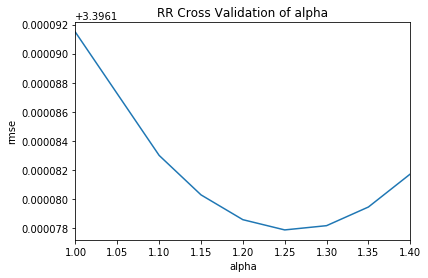

In [36]:
#Tuning alpha value for Ridge:
def rmse_cv(model, x, y):
    #List of scoring params: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

rr_alphas = [1, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4]

cv_ridge = [rmse_cv(Ridge(alpha = alpha), x_train, y_train).mean() 
            for alpha in rr_alphas]

#Convert the list to a Pandas Series, using alphas as the index
cv_ridge = pd.Series(cv_ridge, index = rr_alphas)

#This shows the cross-validation score produced for each alpha
#The alpha with the lowest rmse score is the one we should use.
cv_ridge.plot(title = "RR Cross Validation of alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")


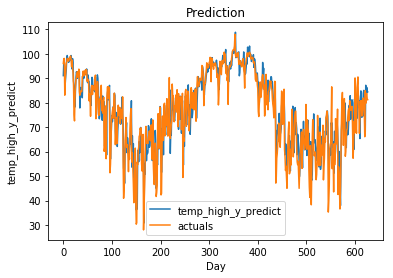

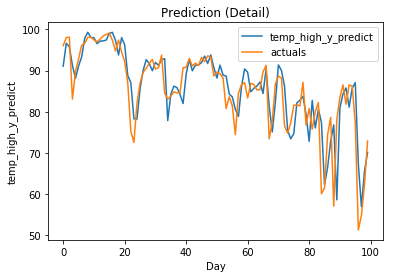

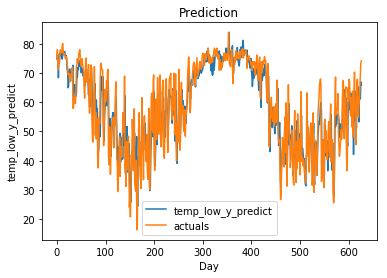

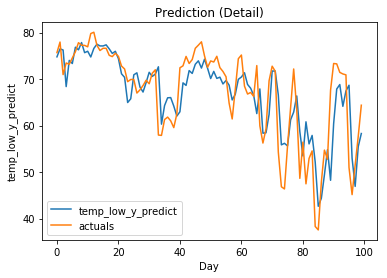

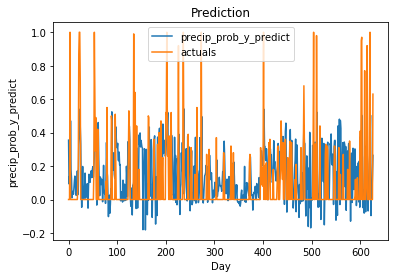

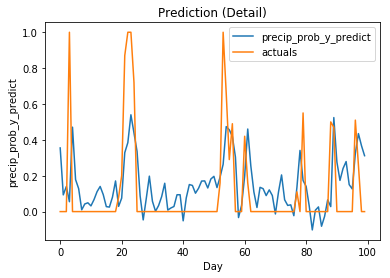

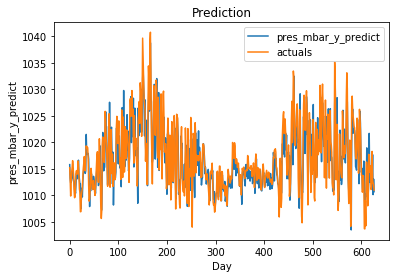

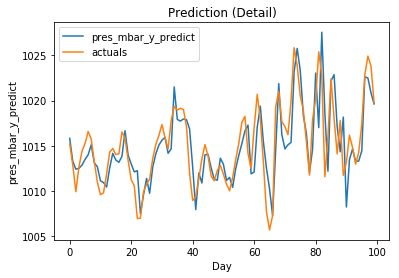

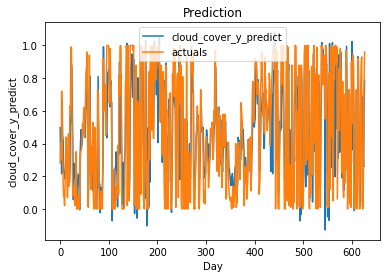

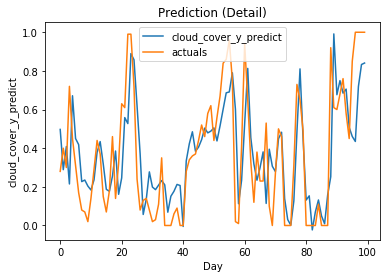

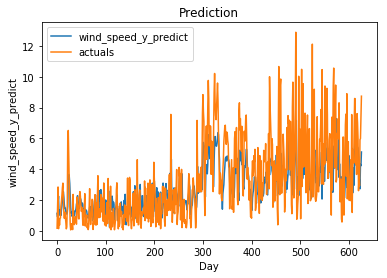

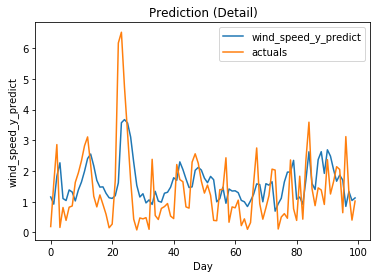

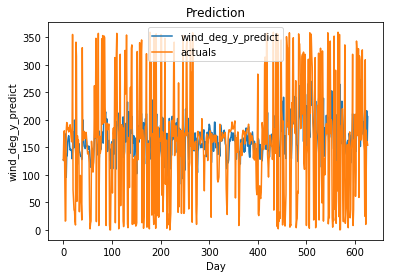

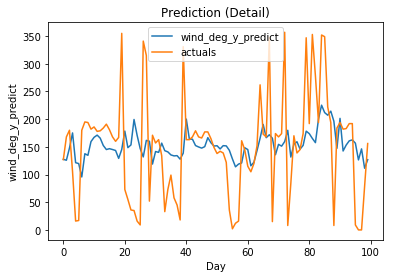

['weather_models.pkl']

In [52]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib  #Used to save the model to a 'pickle file'


#No benefit with normalization....
#full_data = np.log1p(full_data)

#full_train = full_data
#full_test = full_data

full_train = full_data[:3500]
full_test = full_data[3500:]

y_cols = ['temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y']
y_test = ['temp_high_y']

saved_models = {}
for col in y_cols:
   
    #Store the current y column
    y_train = full_train[col]
    y_test = full_test[col]
    
    #Remove all the y columns from the x_data
    x_train = full_train.drop(columns = y_cols, axis=1)
    x_test = full_test.drop(columns = y_cols, axis=1)

    ridge_model = Ridge(alpha=1.25)
    ridge_model.fit(x_train.values, y_train.values)
    saved_models[col] = ridge_model
    
    predict_label = col + "_predict"
    
    predict_ridge = pd.DataFrame(ridge_model.predict(x_test.values))
    predict_ridge.columns = [predict_label]
    predict_ridge['actuals'] = y_test.values
    
    plt.plot(predict_ridge[predict_label])
    plt.plot(predict_ridge['actuals'])
    plt.xlabel('Day')
    plt.ylabel(predict_label)
    plt.title('Prediction')
    plt.legend()
    plt.show()

    plt.plot(predict_ridge[predict_label][:100])
    plt.plot(predict_ridge['actuals'][:100])
    plt.xlabel('Day')
    plt.ylabel(predict_label)
    plt.title('Prediction (Detail)')
    plt.legend()
    plt.show()

    
# Save the models to a file on disk ("Pickle file")
# Saved with full data training; do not overwrite using partial data-trained model!!
#joblib.dump(saved_models, "weather_models.pkl")
    
# Load the pickle file
#saved_models = joblib.load(pkl_file)

In [1]:
#########################
## Bunch of functions 
#########################

def predict(pred_date, feature):
    import pandas as pd
    if feature[-2:] != '_y':
        feature = feature + '_y'
    
    import psycopg2 as pg
    conn = pg.connect(dbname="postgres", user="postgres", password="postgres")
    curr = conn.cursor()
    
    from sklearn.externals import joblib
    saved_models = joblib.load("weather_models.pkl")
    #saved_models = joblib.load("weather_models_normalized.pkl")

    #Retrieve the 5 days of data prior to the desired prediction date, excluding the Y data:
    data_query = """SELECT temp_high_1,  temp_low_1, precip_prob_1, pres_mbar_1, cloud_cover_1, wind_speed_1, wind_deg_1
,temp_high_2   ,temp_low_2    ,precip_prob_2 ,pres_mbar_2   ,cloud_cover_2 ,wind_speed_2  ,wind_deg_2    
,temp_high_3   ,temp_low_3    ,precip_prob_3 ,pres_mbar_3   ,cloud_cover_3 ,wind_speed_3  ,wind_deg_3    
,temp_high_4   ,temp_low_4    ,precip_prob_4 ,pres_mbar_4   ,cloud_cover_4 ,wind_speed_4  ,wind_deg_4    
,temp_high_5   ,temp_low_5    ,precip_prob_5 ,pres_mbar_5   ,cloud_cover_5 ,wind_speed_5  ,wind_deg_5   
FROM weather_data_training WHERE rec_date_1 = cast('{}' as date)-interval '5' day"""
    
    curr.execute(data_query.format(pred_date))
    
    x_data = pd.DataFrame(curr.fetchall(), columns=[
 'temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5'])
    
    model = saved_models[feature]
    prediction = model.predict(x_data.values)    
    return float(round(prediction[0],2))


def actual(pred_date, feature):
    if feature[-2:] == '_y':
        feature = feature[:-2]
    
    import psycopg2 as pg
    conn = pg.connect(dbname="postgres", user="postgres", password="postgres")
    curr = conn.cursor()
    
    #Retrieve the 5 days of data prior to the desired prediction date, excluding the Y data:
    data_query = """SELECT {} FROM weather_data WHERE rec_date = cast('{}' as date)"""
    
    curr.execute(data_query.format(feature, pred_date))
    
    result = curr.fetchall()
    if len(result) > 0:
        result = result[0][0]
    else:
        result = 0.0
        
    return float(round(result,2))

def actual_all(pred_date):
    y_cols = ['temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y']
    results = {}
    for col in y_cols:
        results[col] = actual(pred_date, col)
    
    print("ACTUALS:", pred_date.strftime("%Y-%m-%d"))
    print("High Temp:", round(results['temp_high_y'],2))
    print("Low Temp:", round(results['temp_low_y'],2))
    print("Precip Prob:", round(results['precip_prob_y'],2))
    print("Pressure:", round(results['pres_mbar_y'],2))
    print("Cloud Cover:", round(results['cloud_cover_y'],2))
    print("Wind Speed:", round(results['wind_speed_y'],2))
    print("Wind Dir:", round(results['wind_deg_y'],2))

def mean_abs_error(feature):
    #This will calculate the mean absolute error for a feature
    #using the predictions and actuals from Jan 2019 through Mar 2019.
    import datetime as dt
    pred_date = dt.datetime(2019,1,1,0,0,0)
    end_date = dt.datetime(2019, 4, 1, 0, 0, 0)
    count = 1.0
    sum_abs = 0
    while (pred_date < end_date):
        str_date = pred_date.strftime("%Y-%m-%d")
        sum_abs += abs(actual(str_date, feature) - predict(str_date, feature))
        pred_date += dt.timedelta(days=1)
        count += 1.0
    return round((sum_abs / count), 2)

def mean_abs_deviation(feature):
    ##This will calculate the mean absolute deviation of a feature from Jan 2019 through Mar 2019
    ## mean_abs_deviation is sqrt(1/n * sum( (val - mean)^2 ))
    import datetime as dt
    from math import sqrt
    
    pred_date = dt.datetime(2019,1,1,0,0,0)
    end_date = dt.datetime(2019,4,1,0,0,0)
    
    ##First calculate the mean
    count = 1.0
    sum_error = 0.0
    while (pred_date < end_date):
        str_date = pred_date.strftime("%Y-%m-%d")
        sum_error += abs(actual(str_date, feature) - predict(str_date, feature))
        pred_date += dt.timedelta(days=1)
        count += 1.0
    mean = round((sum_error / count), 2)
    
    ##Then calculate the stddev
    pred_date = dt.datetime(2019,1,1,0,0,0)
    sum_error_sqrd = 0.0
    while (pred_date < end_date):
        str_date = pred_date.strftime("%Y-%m-%d")
        sum_error_sqrd += (abs(actual(str_date, feature) - predict(str_date, feature)) - mean)**2
        pred_date += dt.timedelta(days=1)
    avg_error_sqrd = sum_error_sqrd / count
    std_dev = sqrt(avg_error_sqrd)
    return round(std_dev, 2)
    


def get_x_vals(pred_date):
    import pandas as pd
    import psycopg2 as pg
    conn = pg.connect(dbname="postgres", user="postgres", password="postgres")
    curr = conn.cursor()

    #Retrieve the 5 days of data prior to the desired prediction date, excluding the Y data:
    data_query = """SELECT temp_high_1,  temp_low_1, precip_prob_1, pres_mbar_1, cloud_cover_1, wind_speed_1, wind_deg_1
,temp_high_2   ,temp_low_2    ,precip_prob_2 ,pres_mbar_2   ,cloud_cover_2 ,wind_speed_2  ,wind_deg_2    
,temp_high_3   ,temp_low_3    ,precip_prob_3 ,pres_mbar_3   ,cloud_cover_3 ,wind_speed_3  ,wind_deg_3    
,temp_high_4   ,temp_low_4    ,precip_prob_4 ,pres_mbar_4   ,cloud_cover_4 ,wind_speed_4  ,wind_deg_4    
,temp_high_5   ,temp_low_5    ,precip_prob_5 ,pres_mbar_5   ,cloud_cover_5 ,wind_speed_5  ,wind_deg_5   
FROM weather_data_training WHERE rec_date_1 = cast('{}' as date)-interval '5' day"""
    
    curr.execute(data_query.format(pred_date))
    
    x_data = pd.DataFrame(curr.fetchall(), columns=[
 'temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5'])
    return x_data



def shift_x_vals(x_vals, pred_dict):
    x_cols = [
 'temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5']
    
    #Shift the x_vals to the left
    for col in x_cols:
        if int(col[-1:]) > 1:
            col_name = col[:-1]
            col_num = int(col[-1:])
            new_col = col_name + str(col_num-1)
            x_vals[new_col] = x_vals[col]
    
    #Load the predictions in to x_vals_5 position
    y_cols = ['temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y']
    for val in y_cols:
        col_name_5 = val[:-1] + "5"  #The _5 column name
        x_vals[col_name_5] = pred_dict[val]
    
    return x_vals
    

def predict_3_days(start_date):
    from sklearn.externals import joblib
    x_vals = get_x_vals(start_date)
    
    saved_models = joblib.load("weather_models.pkl")
    #saved_models = joblib.load("weather_models_normalized.pkl")
    y_cols = ['temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y']
    
    #1st day predictions
    day1 = {}
    for col in y_cols:
        model = saved_models[col]
        day1[col] = model.predict(x_vals)
    
    x_vals = shift_x_vals(x_vals, day1)
    
    #2nd day predictions
    day2 = {}
    for col in y_cols:
        model = saved_models[col]
        day2[col] = model.predict(x_vals)
    
    x_vals = shift_x_vals(x_vals, day2)
    
    #3rd day predictions
    day3 = {}
    for col in y_cols:
        model = saved_models[col]
        day3[col] = model.predict(x_vals)

    return day1, day2, day3



In [40]:
# ERROR and DEVIATION
## Using predict_3_days(start_date), run for Jan-March and capture the day2 data to get mean abs deviation
import datetime as dt
from math import sqrt
pred_date = dt.datetime(2019,1,1,0,0,0)
end_date = dt.datetime(2019, 4, 1, 0, 0, 0)
plus_days = 1  #0 = day1, 1 = day2, 2 = day3
count = 1.0
sum_abs = 0.0
feature = 'precip_prob_y'

while (pred_date < end_date):
    day1, day2, day3 = predict_3_days(pred_date.strftime("%Y-%m-%d"))
    next_day_pred = day2[feature][0]
    next_day = pred_date + dt.timedelta(days=plus_days)
    sum_abs += abs(actual(next_day.strftime("%Y-%m-%d"), feature) - next_day_pred)
    pred_date += dt.timedelta(days=1)
    count += 1.0

mean = round((sum_abs / count), 2)

##Then calculate the stddev
pred_date = dt.datetime(2019,1,1,0,0,0)
sum_error_sqrd = 0.0
while (pred_date < end_date):
    day1, day2, day3 = predict_3_days(pred_date.strftime("%Y-%m-%d"))
    next_day_pred = day2[feature][0]
    next_day = pred_date + dt.timedelta(days=plus_days)
    sum_error_sqrd += (abs(actual(next_day.strftime("%Y-%m-%d"), feature) - next_day_pred) - mean)**2
    pred_date += dt.timedelta(days=1)
    avg_error_sqrd = sum_error_sqrd / count
    std_dev = sqrt(avg_error_sqrd)
    
    
print("mean_abs_error", mean)
print("mean_abs_deviation", round(std_dev, 2))

mean_abs_error 0.16
mean_abs_deviation 0.11


[ 8.86564392e-02 -1.33930005e-03  1.01485789e+00 -3.17070188e-03
  5.17984529e-01  1.39490931e-01 -1.76379379e-03  5.63694270e-02
 -4.20960495e-02  3.39333548e-01  3.82972249e-02 -4.82754626e-01
  4.39276788e-02 -3.11656628e-03  9.00260376e-02 -6.42440424e-02
  2.76404633e-01 -6.12350504e-02  7.42172878e-01  2.19424067e-01
 -2.79402425e-03  5.28506643e-03 -3.95065828e-02 -6.41408740e-02
 -6.98429353e-03  2.29517235e+00  2.90780506e-01 -2.84253042e-03
  2.75993522e-01  6.49775221e-01  9.87684809e-01  2.01535112e-01
 -9.62454045e+00 -3.26166955e-01  9.96514878e-03]


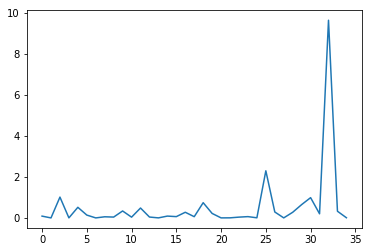

In [45]:
from sklearn.externals import joblib
saved_models = joblib.load("weather_models.pkl")
#saved_models = joblib.load("weather_models_normalized.pkl")


y_cols = ['temp_high_y','temp_low_y','precip_prob_y','pres_mbar_y','cloud_cover_y','wind_speed_y','wind_deg_y']

x_cols = [
 'temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5']

model = saved_models['temp_high_y']
print(model.coef_)

import matplotlib.pyplot as plt
%matplotlib inline

coef = model.coef_

plt.plot(abs(coef))
plt.show()

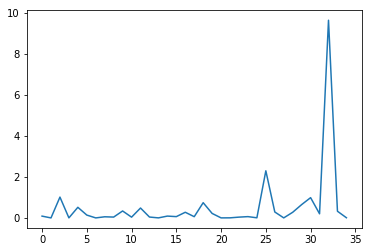

In [46]:
##Precip Prob Coefficients

import matplotlib.pyplot as plt
%matplotlib inline

coef = model.coef_

plt.plot(abs(coef))
plt.show()

In [23]:
x_cols = [
 'temp_high_1','temp_low_1','precip_prob_1','pres_mbar_1','cloud_cover_1','wind_speed_1','wind_deg_1'
,'temp_high_2','temp_low_2','precip_prob_2','pres_mbar_2','cloud_cover_2','wind_speed_2','wind_deg_2'
,'temp_high_3','temp_low_3','precip_prob_3','pres_mbar_3','cloud_cover_3','wind_speed_3','wind_deg_3'
,'temp_high_4','temp_low_4','precip_prob_4','pres_mbar_4','cloud_cover_4','wind_speed_4','wind_deg_4'
,'temp_high_5','temp_low_5','precip_prob_5','pres_mbar_5','cloud_cover_5','wind_speed_5','wind_deg_5']

for x in range(len(coef)):
    print(x_cols[x], "\t", abs(round(abs(coef[x]),4)))

temp_high_1 	 0.0888
temp_low_1 	 0.0008
precip_prob_1 	 0.8673
pres_mbar_1 	 0.0041
cloud_cover_1 	 0.6508
wind_speed_1 	 0.0878
wind_deg_1 	 0.0014
temp_high_2 	 0.0521
temp_low_2 	 0.0366
precip_prob_2 	 0.3684
pres_mbar_2 	 0.0331
cloud_cover_2 	 0.5428
wind_speed_2 	 0.0149
wind_deg_2 	 0.0021
temp_high_3 	 0.0802
temp_low_3 	 0.0577
precip_prob_3 	 0.322
pres_mbar_3 	 0.0693
cloud_cover_3 	 0.5313
wind_speed_3 	 0.1644
wind_deg_3 	 0.0029
temp_high_4 	 0.0063
temp_low_4 	 0.0493
precip_prob_4 	 0.0115
pres_mbar_4 	 0.003
cloud_cover_4 	 2.3879
wind_speed_4 	 0.2933
wind_deg_4 	 0.0023
temp_high_5 	 0.2952
temp_low_5 	 0.6411
precip_prob_5 	 0.9793
pres_mbar_5 	 0.1972
cloud_cover_5 	 9.3517
wind_speed_5 	 0.3319
wind_deg_5 	 0.0101


In [3]:
import datetime as dt
pred_date = dt.datetime.strptime("2019-05-03", "%Y-%m-%d")
day1, day2, day3 = predict_3_days(pred_date.strftime("%Y-%m-%d"))

print("PREDICTION:", pred_date.strftime("%Y-%m-%d"))
print("High Temp:", round(day1['temp_high_y'][0],2))
print("Low Temp:", round(day1['temp_low_y'][0],2))
print("Precip Prob:", round(day1['precip_prob_y'][0],2))
print("Pressure:", round(day1['pres_mbar_y'][0],2))
print("Cloud Cover:", round(day1['cloud_cover_y'][0],2))
print("Wind Speed:", round(day1['wind_speed_y'][0],2))
print("Wind Dir:", round(day1['wind_deg_y'][0],2))
print("\n")
actual_all(pred_date)
print("\n")
pred_date += dt.timedelta(days=1)
print("PREDICTION:", pred_date.strftime("%Y-%m-%d"))
print("High Temp:", round(day2['temp_high_y'][0],2))
print("Low Temp:", round(day2['temp_low_y'][0],2))
print("Precip Prob:", round(day2['precip_prob_y'][0],2))
print("Pressure:", round(day2['pres_mbar_y'][0],2))
print("Cloud Cover:", round(day2['cloud_cover_y'][0],2))
print("Wind Speed:", round(day2['wind_speed_y'][0],2))
print("Wind Dir:", round(day2['wind_deg_y'][0],2))
print("\n")
actual_all(pred_date)
print("\n")
pred_date += dt.timedelta(days=1)
print("PREDICTION:", pred_date.strftime("%Y-%m-%d"))
print("High Temp:", round(day3['temp_high_y'][0],2))
print("Low Temp:", round(day3['temp_low_y'][0],2))
print("Precip Prob:", round(day3['precip_prob_y'][0],2))
print("Pressure:", round(day3['pres_mbar_y'][0],2))
print("Cloud Cover:", round(day3['cloud_cover_y'][0],2))
print("Wind Speed:", round(day3['wind_speed_y'][0],2))
print("Wind Dir:", round(day3['wind_deg_y'][0],2))
print("\n")
actual_all(pred_date)




PREDICTION: 2019-05-03
High Temp: 79.21
Low Temp: 64.45
Precip Prob: 0.39
Pressure: 1014.54
Cloud Cover: 0.65
Wind Speed: 3.72
Wind Dir: 143.83


ACTUALS: 2019-05-03
High Temp: 79.05
Low Temp: 60.89
Precip Prob: 0.99
Pressure: 1012.02
Cloud Cover: 0.94
Wind Speed: 2.92
Wind Dir: 77.0


PREDICTION: 2019-05-04
High Temp: 82.67
Low Temp: 63.76
Precip Prob: 0.25
Pressure: 1013.36
Cloud Cover: 0.53
Wind Speed: 3.64
Wind Dir: 163.01


ACTUALS: 2019-05-04
High Temp: 0.0
Low Temp: 0.0
Precip Prob: 0.0
Pressure: 0.0
Cloud Cover: 0.0
Wind Speed: 0.0
Wind Dir: 0.0


PREDICTION: 2019-05-05
High Temp: 83.76
Low Temp: 63.86
Precip Prob: 0.19
Pressure: 1013.24
Cloud Cover: 0.45
Wind Speed: 3.58
Wind Dir: 151.71


ACTUALS: 2019-05-05
High Temp: 0.0
Low Temp: 0.0
Precip Prob: 0.0
Pressure: 0.0
Cloud Cover: 0.0
Wind Speed: 0.0
Wind Dir: 0.0
